Образовательный центр МГТУ им. Н.Э. Баумана

Выполнил: Четвериков А.В.

## 4. Разработка и обучение моделей прогнозирующих модуль упругости при растяжении и прочность при растяжении

In [1]:
# Загрузим необходимые библиотеки и модули 

import pathlib               #для задания относительного пути к файлам
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model




In [2]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True)
df = pd.DataFrame(data= np.c_[df['data'], df['target']],columns= df['feature_names'] + ['target'])

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Удалим выборосы методом 3-х сигм
m_3s = pd.DataFrame(index=df.index)
for column in df:
    zscore = (df[column] - df[column].mean()) / df[column].std()
    m_3s[column] = (zscore.abs() > 3)
df = df[m_3s.sum(axis=1)==0]
df.shape

(19794, 9)

In [4]:
# удалим выборосы методом 3-х сигм
m = df.copy()
for i in df.columns:
    m[i] = abs((df[i] - df[i].mean()) / df[i].std())
    print(f"{sum(m[i] > 3)} выбросов в признаке {i}")
print(f' Всего {sum(sum(m.values > 3))} выброса')

147 выбросов в признаке MedInc
0 выбросов в признаке HouseAge
151 выбросов в признаке AveRooms
387 выбросов в признаке AveBedrms
360 выбросов в признаке Population
144 выбросов в признаке AveOccup
0 выбросов в признаке Latitude
0 выбросов в признаке Longitude
0 выбросов в признаке target
 Всего 1189 выброса


In [5]:
# Удалим выборосы методом 3-х сигм
for i in range(1, 20, 1):
    m_3s = pd.DataFrame(index=df.index)
    for column in df:
        zscore = (df[column] - df[column].mean()) / df[column].std()
        m_3s[column] = (zscore.abs() > 3)
    df = df[m_3s.sum(axis=1)==0]

df.shape

(17294, 9)

In [6]:
# удалим выборосы методом 3-х сигм
m = df.copy()
for i in df.columns:
    m[i] = abs((df[i] - df[i].mean()) / df[i].std())
    print(f"{sum(m[i] > 3)} выбросов в признаке {i}")
print(f' Всего {sum(sum(m.values > 3))} выброса')

0 выбросов в признаке MedInc
0 выбросов в признаке HouseAge
0 выбросов в признаке AveRooms
0 выбросов в признаке AveBedrms
0 выбросов в признаке Population
0 выбросов в признаке AveOccup
0 выбросов в признаке Latitude
0 выбросов в признаке Longitude
0 выбросов в признаке target
 Всего 0 выброса


In [7]:
# разделим датасет на целевую переменную и признаки

In [8]:
target_val = 'target'

In [9]:
df_target_val = df.loc[:, df.columns == target_val]
df_target_val.describe()

,target
count,17294.000000
mean,2.022433
std,1.078222
min,0.149990
25%,1.199000
50%,1.804000
75%,2.594750
max,5.000010


In [10]:
df_signs = df.loc[:, df.columns != target_val]
df_signs.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,17294.000000,17294.000000,17294.000000,17294.000000,17294.000000,17294.000000,17294.000000,17294.000000
mean,3.711904,29.697236,5.161490,1.047972,1266.229617,2.869152,35.641298,-119.616476
std,1.503885,12.256234,1.065653,0.068549,630.792598,0.660838,2.126529,1.990995
min,0.499900,1.000000,1.968051,0.842365,5.000000,0.970588,32.540000,-124.350000
25%,2.568500,20.000000,4.416573,1.002821,807.000000,2.421395,33.940000,-121.820000
50%,3.523400,30.000000,5.143017,1.044376,1154.000000,2.806690,34.270000,-118.530000
75%,4.652800,38.000000,5.867753,1.089871,1628.000000,3.250601,37.720000,-118.040000
max,8.215900,52.000000,8.357664,1.253472,3157.000000,4.850144,41.950000,-114.570000


In [11]:
# нормализуем наши датасеты

In [12]:
# отдельно целевая, отдельно признаки

In [13]:
# 1 - Normalizer()
# 2 - MinMaxScaler()
# 3 - StandardScaler()
# 4 - normalize()


preobraz = (2,)

df_target_val_norm = df_target_val
df_signs_norm = df_signs

for n in preobraz:
    if n == 1:
        norm_1 = Normalizer(norm = 'l2', copy = True)
        col = df_target_val.columns
        result = norm_1.fit_transform(df_target_val_norm.T)
        df_target_val_norm = pd.DataFrame(result.T, columns = col)
        
        norm_2 = Normalizer(norm = 'l2', copy = True)
        col = df_signs.columns
        result = norm_2.fit_transform(df_signs_norm.T)
        df_signs_norm = pd.DataFrame(result.T, columns = col)
        
        
        
    if n == 2:
        scaler_1 = MinMaxScaler((0.1, 0.9))
        col = df_target_val.columns
        result = scaler_1.fit_transform(df_target_val_norm)
        df_target_val_norm = pd.DataFrame(result, columns = col)
        
        scaler_2 = MinMaxScaler((0.1, 0.9))
        col = df_signs.columns
        result = scaler_2.fit_transform(df_signs_norm)
        df_signs_norm = pd.DataFrame(result, columns = col)
        
     
        
        
        
    if n == 3:
        scaler_1 = StandardScaler(copy = True, 
                           with_mean = True, 
                           with_std = True).fit(df_target_val_norm)
        df_standart_X1 = scaler_1.transform(df_target_val_norm)
        df_target_val_std = pd.DataFrame(df_standart_X1)
        df_target_val_std.columns = df_target_val.columns
        df_target_val_norm = df_target_val_std
        
        scaler_2 = StandardScaler(copy = True, 
                           with_mean = True, 
                           with_std = True).fit(df_signs_norm)
        df_standart_X2 = scaler_2.transform(df_signs_norm)
        df_signs_std = pd.DataFrame(df_standart_X2)
        df_signs_std.columns = df_signs.columns
        df_signs_norm = df_signs_std
        

        
        
    if n == 4:
        res_1, k_norm_1 = preprocessing.normalize(df_target_val_norm, norm='l2', return_norm = True, axis=0)
        df_target_val_norm = pd.DataFrame(res_1, columns = df_target_val.columns)
        
        res_2, k_norm_2 = preprocessing.normalize(df_signs_norm, norm='l2', return_norm = True, axis=0)
        df_signs_norm = pd.DataFrame(res_2, columns = df_signs.columns)
        


Text(0.5, 1, '4')

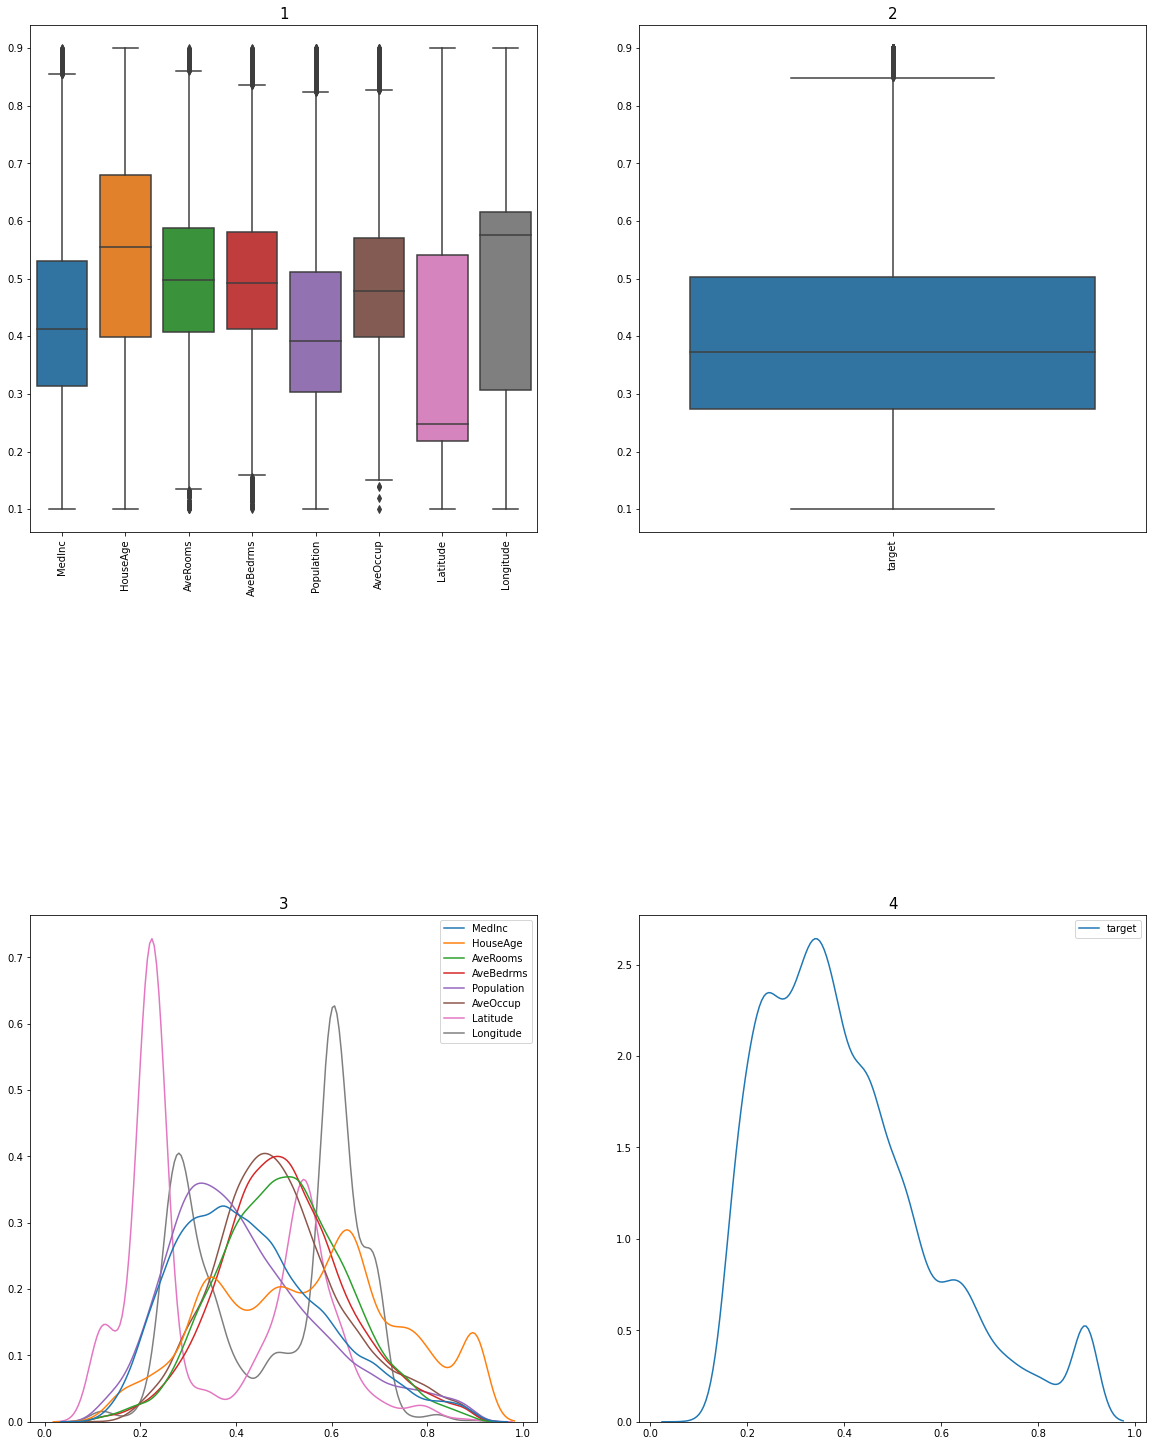

In [14]:


plt.figure(figsize = (20,30))


plt.subplot(2, 2, 1, box_aspect= 1)
ax = sns.boxplot(data = df_signs_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('1', y = 1, size = 15)

plt.subplot(2, 2, 2, box_aspect= 1)
ax = sns.boxplot(data = df_target_val_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('2', y = 1, size = 15) 

plt.subplot(2, 2, 3, box_aspect= 1)
sns.kdeplot(data=df_signs_norm)
plt.ylabel(None)
plt.xlabel(None)
plt.title('3', y = 1, size = 15)

plt.subplot(2, 2, 4, box_aspect= 1)
sns.kdeplot(data=df_target_val_norm)
plt.ylabel(None)
plt.xlabel(None)
plt.title('4', y = 1, size = 15)
    

Выделим из датасета прогнозируемую (зависимую) переменную. И разделим выборку на обучающую и тестовую выборки, в соответствии с условием задачи 70% (на обучение) /30% (на тестирование)


In [15]:
#разбиваем на тестовую, тренировочную выборки, выделяя предикторы и целевые переменные
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    df_signs_norm,
    df_target_val_norm,
       test_size = 0.3,
    random_state = 42)

In [16]:
# Проверка правильности разбивки
df.shape[0] - x_train_1.shape[0] - x_test_1.shape[0]

0

In [17]:
x_train_1.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14130,0.743266,0.366667,0.629508,0.500696,0.551523,0.407273,0.524230,0.265235
5354,0.487849,0.711765,0.566546,0.470271,0.568528,0.466166,0.237726,0.620245
13869,0.487890,0.507843,0.659490,0.560705,0.293655,0.401022,0.332094,0.402658
5545,0.420249,0.774510,0.512637,0.556083,0.448223,0.580791,0.240276,0.606339
13882,0.532556,0.460784,0.720613,0.464439,0.476904,0.507073,0.335494,0.398569


In [18]:
y_train_1.head()

,target
14130,0.756494
5354,0.507423
13869,0.502309
5545,0.328454
13882,0.631133


In [19]:
x_test_1.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
17282,0.272815,0.649020,0.676567,0.554691,0.226650,0.507630,0.664506,0.338855
1346,0.625008,0.680392,0.641269,0.423923,0.304061,0.390512,0.554835,0.286503
15333,0.455044,0.774510,0.389018,0.423125,0.550254,0.340777,0.514878,0.279959
431,0.340695,0.900000,0.453918,0.524860,0.298731,0.369488,0.552285,0.269325
6913,0.432110,0.649020,0.639474,0.483712,0.211421,0.417126,0.207970,0.611247


In [20]:
y_test_1.head()

,target
17282,0.229980
1346,0.518639
15333,0.742968
431,0.346269
6913,0.479876


In [21]:
y_test_1 = np.ravel(y_test_1)
y_train_1 = np.ravel(y_train_1)

In [22]:
y_test_1.shape

(5189,)

## Линейная регрессия

In [23]:
#построение модели Линейной регрессии
lr = LinearRegression()

In [24]:
# определим гиперпараметры для подбора
param_grid_lr = {'fit_intercept': [True, False],
               'positive': [True, False]}

In [25]:
# запускаем GridSearch для поиска оптимальных гиперпараметров
gs_lr = GridSearchCV(lr, param_grid_lr, cv = 10, verbose = 1, scoring = 'r2')
gs_lr.fit(x_train_1, y_train_1)

# отобразим лучший результат
print()
print("_______Оптимальные параметры:")
print(gs_lr.best_params_)
lr = gs_lr.best_estimator_
print()
print(f'R2-score DTR для модуля упругости при растяжении: {lr.score(x_test_1, y_test_1).round(3)}')


Fitting 10 folds for each of 4 candidates, totalling 40 fits

_______Оптимальные параметры:
{'fit_intercept': True, 'positive': False}

R2-score DTR для модуля упругости при растяжении: 0.629


In [26]:
# оценка модели
best_model = lr
y_pred = best_model.predict(x_test_1)
print('***Результат на тренировочной выборке***')
print("Test score: {:.2f}".format(best_model.score(x_train_1, y_train_1)))
print()
print('***Результат на тестовой выборке***')    
print('lr_MAE: {:.2f}'.format(mean_absolute_error(y_test_1, y_pred)))
print('lr_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred)))
print('lr_MSE: {:.2f}'.format(mean_squared_error(y_test_1, y_pred)))
print("lr_RMSE: {:.2f}".format (np.sqrt(mean_squared_error(y_test_1, y_pred))))
print("Test score: {:.2f}".format(best_model.score(x_test_1, y_test_1)))

***Результат на тренировочной выборке***
Test score: 0.65

***Результат на тестовой выборке***
lr_MAE: 0.08
lr_MAPE: 0.21
lr_MSE: 0.01
lr_RMSE: 0.11
Test score: 0.63


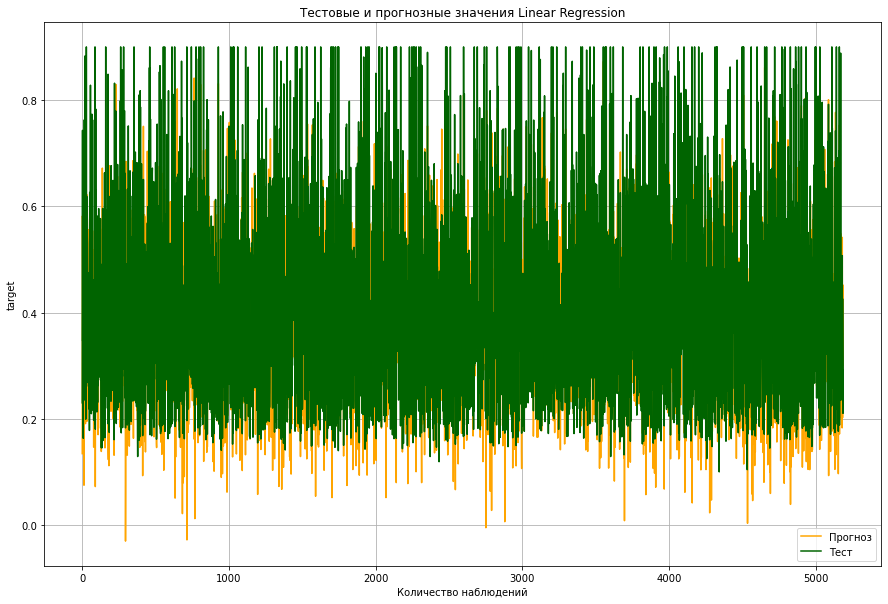

In [27]:
# нарисуем график предсказанных и фактических значений по тестовой выборке
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Linear Regression")
plt.plot(y_pred, label="Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

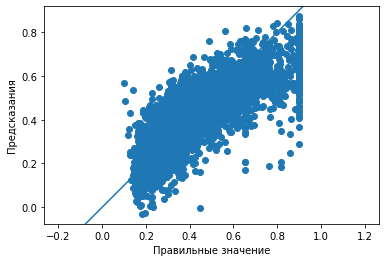

In [28]:
plt.scatter(y_test_1, y_pred) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

## Метод опорных векторов

In [28]:
#class sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, 
#                     shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svr = SVR()

In [29]:
# определим гиперпараметры для подбора
param_grid_svr = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                 'degree': [1,2,3,4,5,6,10],
                 'gamma': ['scale', 'auto'],
#                 'coef0': [0.0,0.1,0.5,10.0],
#                 'tol': [0.0005,0.001,0.005,1.0],
#                 'C': [0.5,1.0,1.5,5.0],
#                 'epsilon': [0.05,0.1,0.2,1.0],
                 'shrinking': [True, False],
#                 'cache_size': [100,200,500]
                }

In [ ]:
# запускаем GridSearch для поиска оптимальных гиперпараметров
gs_svr = GridSearchCV(svr, param_grid_svr, cv = 10, verbose = 1, scoring = 'r2')
gs_svr.fit(x_train_1, y_train_1)

# отобразим лучший результат
print()
print("_______Оптимальные параметры:")
print(gs_svr.best_params_)
svr = gs_svr.best_estimator_
print()
print(f'R2-score DTR для модуля упругости при растяжении: {svr.score(x_test_1, y_test_1).round(3)}')

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [ ]:
# оценка модели
best_model = svr
y_pred = best_model.predict(x_test_1)
print('***Результат на тренировочной выборке***')
print("Test score: {:.2f}".format(best_model.score(x_train_1, y_train_1)))
print()
print('***Результат на тестовой выборке***')    
print('lr_MAE: {:.2f}'.format(mean_absolute_error(y_test_1, y_pred)))
print('lr_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred)))
print('lr_MSE: {:.2f}'.format(mean_squared_error(y_test_1, y_pred)))
print("lr_RMSE: {:.2f}".format (np.sqrt(mean_squared_error(y_test_1, y_pred))))
print("Test score: {:.2f}".format(best_model.score(x_test_1, y_test_1)))

In [ ]:
# нарисуем график предсказанных и фактических значений по тестовой выборке
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Linear Regression")
plt.plot(y_pred, label="Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Метод случайного леса - Random Forest Regressor

In [25]:
#построение модели и вузуализация метода случайный лес
# class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, 
#      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, 
#      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
#      warm_start=False, ccp_alpha=0.0, max_samples=None)

rfr = RandomForestRegressor(max_depth= None, 
                            n_estimators=300, 
                            random_state=42, 
                            criterion= 'absolute_error', 
                            max_features = None, 
                            bootstrap = True,
                            oob_score = True,
                            verbose = 0,
                            max_samples = 10)
rfr.fit(x_train_1, np.ravel(y_train_1))
y_pred_forest = rfr.predict(x_test_1)
mae_rfr = mean_absolute_error(y_pred_forest, y_test_1)
mse_rfr_elast = mean_squared_error(y_test_1,y_pred_forest)
print('Random Forest Regressor Results Train:')
print("Test score: {:.2f}".format(rfr.score(x_train_1, y_train_1))) # Скор для тренировочной выборки
print('Random Forest Regressor Results:')
print('RF_MAE: ', round(mean_absolute_error(y_test_1, y_pred_forest)))
print('RF_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_forest)))
print('RF_MSE: {:.2f}'.format(mse_rfr_elast))
print("RF_RMSE: {:.2f}".format (np.sqrt(mse_rfr_elast)))
print("Test score: {:.2f}".format(rfr.score(x_test_1, y_test_1))) # Скор для тестовой выборки


Random Forest Regressor Results Train:
Test score: 0.02
Random Forest Regressor Results:
RF_MAE:  0
RF_MAPE: 1.14
RF_MSE: 0.00
RF_RMSE: 0.03
Test score: -0.01


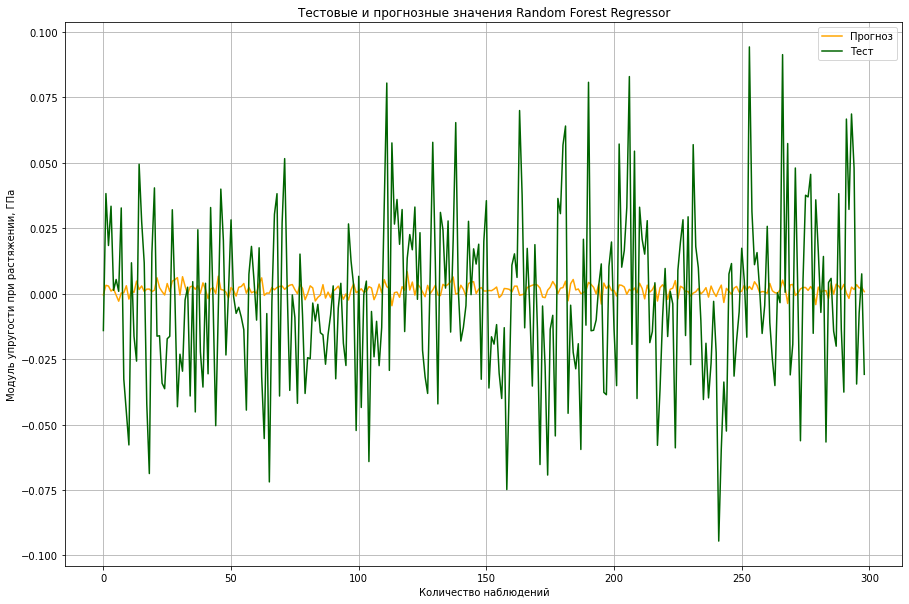

In [26]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Random Forest Regressor")
plt.plot(y_pred_forest, label = "Прогноз", color = "orange")
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Метода градиентного бустинга

In [27]:
#class sklearn.ensemble.GradientBoostingRegressor(*, loss='squared_error', learning_rate=0.1, n_estimators=100, 
#       subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#       max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#       max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

gbr = GradientBoostingRegressor(random_state=42,
                               loss = 'absolute_error',
                               criterion = 'squared_error',
                               max_depth = 10,
                               max_features = 'log2')
gbr.fit(x_train_1, np.ravel(y_train_1))
y_pred_gbr = gbr.predict(x_test_1)
mae_gbr = mean_absolute_error(y_pred_gbr, y_test_1)
mse_gbr_elast = mean_squared_error(y_test_1,y_pred_gbr)
print('Gradient Boosting Regressor Results Train:')
print("Test score: {:.2f}".format(gbr.score(x_train_1, y_train_1))) # Скор для тренировочной выборки
print('Gradient Boosting Regressor Results:')
print('GBR_MAE: ', round(mean_absolute_error(y_test_1, y_pred_gbr)))
print('GBR_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_gbr)))
print('GBR_MSE: {:.2f}'.format(mse_gbr_elast))
print("GBR_RMSE: {:.2f}".format (np.sqrt(mse_gbr_elast)))
print("Test score: {:.2f}".format(gbr.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Gradient Boosting Regressor Results Train:
Test score: 0.88
Gradient Boosting Regressor Results:
GBR_MAE:  0
GBR_MAPE: 1.71
GBR_MSE: 0.00
GBR_RMSE: 0.03
Test score: -0.10


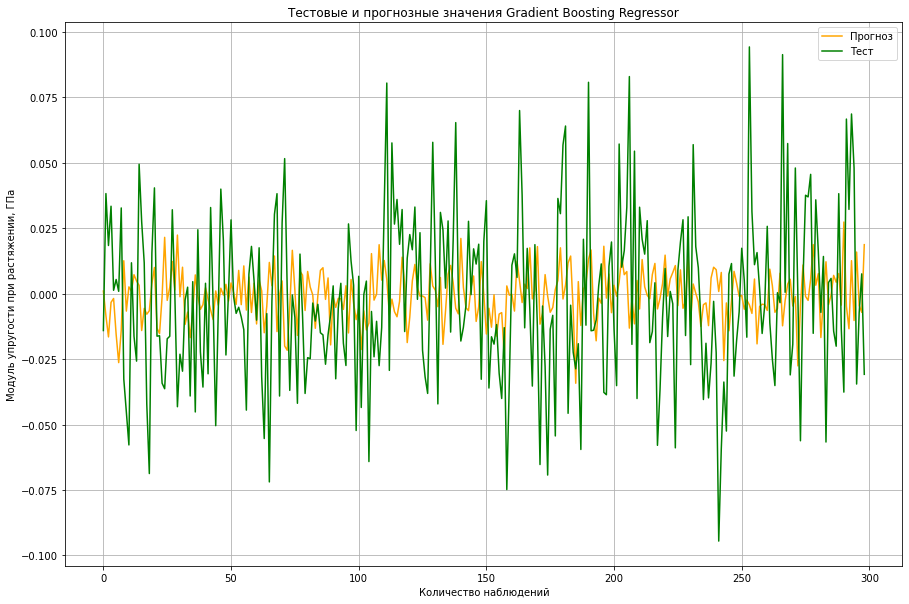

In [28]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Gradient Boosting Regressor")
plt.plot(y_pred_gbr, label = "Прогноз", color = "orange")
plt.plot(y_test_1, label = "Тест", color = "green")
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Метод К ближайших соседей

In [29]:
#class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, 
#     p=2, metric='minkowski', metric_params=None, n_jobs=None)
knn = KNeighborsRegressor(n_neighbors=100,
                         weights = 'distance',
                         algorithm = 'auto')
knn.fit(x_train_1, y_train_1)
y_pred_knn = knn.predict(x_test_1)
mae_knr = mean_absolute_error(y_pred_knn, y_test_1)
mse_knn_elast = mean_squared_error(y_test_1,y_pred_knn)
print('K Neighbors Regressor  Results Train:')
print("Test score: {:.2f}".format(knn.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('K Neighbors Regressor  Results:')
print('KNN_MAE: ', round(mean_absolute_error(y_test_1, y_pred_knn)))
print('KNN_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_knn)))
print('KNN_MSE: {:.2f}'.format(mse_knn_elast))
print("KNN_RMSE: {:.2f}".format (np.sqrt(mse_knn_elast)))
print("Test score: {:.2f}".format(knn.score(x_test_1, y_test_1)))# Скор для тестовой выборки

K Neighbors Regressor  Results Train:
Test score: 1.00
K Neighbors Regressor  Results:
KNN_MAE:  0
KNN_MAPE: 1.19
KNN_MSE: 0.00
KNN_RMSE: 0.03
Test score: -0.01


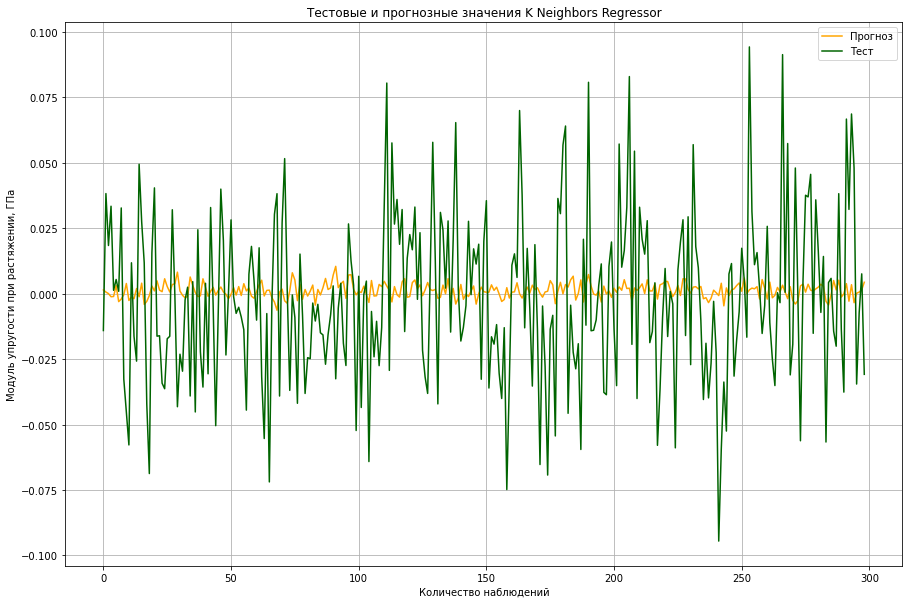

In [30]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения K Neighbors Regressor")
plt.plot(y_pred_knn, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Деревья решений

In [31]:
#class sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, 
#       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
#       max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
dtr2 = DecisionTreeRegressor(criterion = 'squared_error',
                            splitter = 'best',
                            max_depth = 1000000,
                            max_features = None,
                            random_state = 42)
dtr2.fit(x_train_1, y_train_1)
y_pred_dtr = dtr2.predict(x_test_1)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test_1)
mse_dtr_elast = mean_squared_error(y_test_1,y_pred_dtr)
print('Decision Tree Regressor Results Train:')
print("Test score: {:.2f}".format(knn.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Decision Tree Regressor Results:')
print('DTR_MAE: ', round(mean_absolute_error(y_test_1, y_pred_dtr)))
print('DTR_MSE: {:.2f}'.format(mse_dtr_elast))
print("DTR_RMSE: {:.2f}".format (np.sqrt(mse_dtr_elast)))
print('DTR_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_dtr)))
print("Test score: {:.2f}".format(dtr2.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Decision Tree Regressor Results Train:
Test score: 1.00
Decision Tree Regressor Results:
DTR_MAE:  0
DTR_MSE: 0.00
DTR_RMSE: 0.05
DTR_MAPE: 4.07
Test score: -1.14


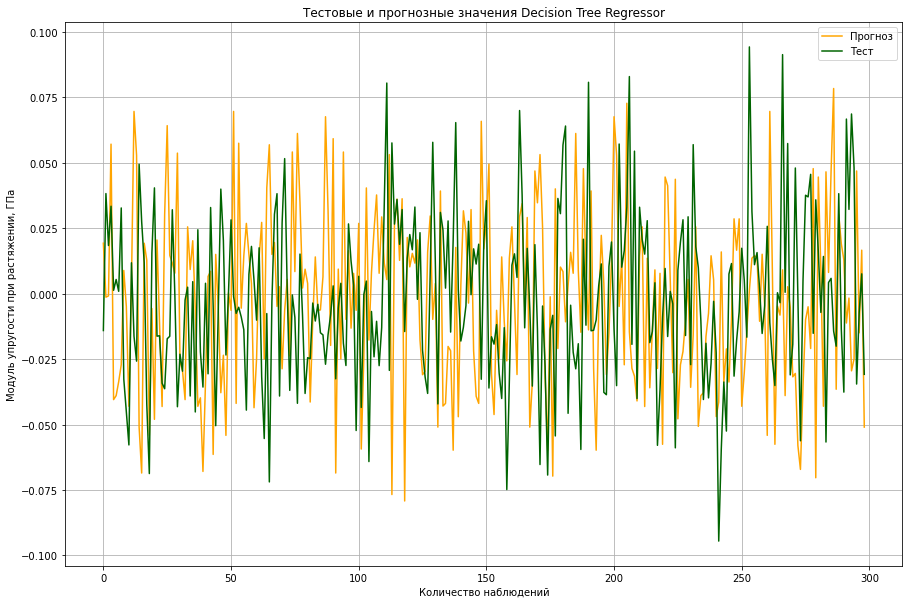

In [32]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Decision Tree Regressor")
plt.plot(y_pred_dtr, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Стохастический градиентный спуск

In [33]:
#class sklearn.linear_model.SGDRegressor(loss='squared_error', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, 
#      fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, 
#      learning_rate='invscaling', eta0=0.01, power_t=0.25, early_stopping=False, validation_fraction=0.1, 
#       n_iter_no_change=5, warm_start=False, average=False)
sdg = SGDRegressor(penalty = 'elasticnet',
                  max_iter = 100000,
                  random_state = 42,
                  learning_rate = 'optimal')
sdg.fit(x_train_1, y_train_1)
y_pred_sdg = sdg.predict(x_test_1)
mae_sdg = mean_absolute_error(y_pred_sdg, y_test_1)
mse_sdg_elast = mean_squared_error(y_test_1,y_pred_sdg)
print('Stochastic Gradient Descent Regressor Results Train:')
print("Test score: {:.2f}".format(sdg.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Stochastic Gradient Descent Regressor Results:')
print('SGD_MAE: ', round(mean_absolute_error(y_test_1, y_pred_sdg)))
print('SGD_MSE: {:.2f}'.format(mse_sdg_elast))
print("SGD_RMSE: {:.2f}".format (np.sqrt(mse_sdg_elast)))
print('SGD_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_sdg)))
print("Test score: {:.2f}".format(sdg.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Stochastic Gradient Descent Regressor Results Train:
Test score: -11.16
Stochastic Gradient Descent Regressor Results:
SGD_MAE:  0
SGD_MSE: 0.01
SGD_RMSE: 0.12
SGD_MAPE: 14.99
Test score: -13.16


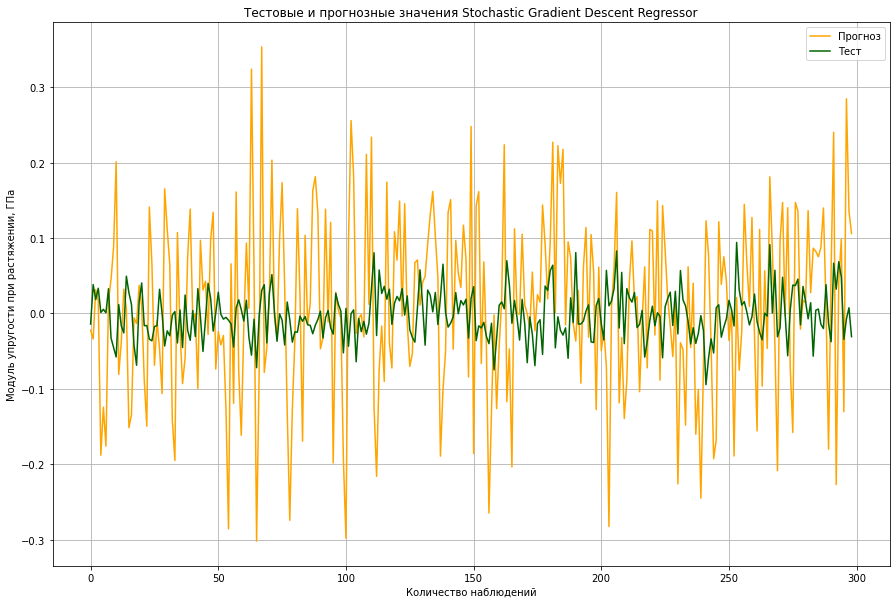

In [34]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Stochastic Gradient Descent Regressor")
plt.plot(y_pred_sdg, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Многослойный перцептрон

In [35]:
# class sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', 
#       alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
#       max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, 
#       momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
#       beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

mlp = MLPRegressor(random_state = 42,
                   hidden_layer_sizes = (48, 48),
                   activation = 'tanh',
                   solver = 'adam',
                   batch_size = 'auto',
                   learning_rate = 'constant',
                   max_iter = 10000)
mlp.fit(x_train_1, y_train_1)
y_pred_mlp = mlp.predict(x_test_1)
mae_mlp = mean_absolute_error(y_pred_mlp, y_test_1)
mse_mlp_elast = mean_squared_error(y_test_1,y_pred_mlp)
print('Multi-layer Perceptron regressor Results Train:')
print("Test score: {:.2f}".format(mlp.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Multi-layer Perceptron regressor Results:')
print('SGD_MAE: ', round(mean_absolute_error(y_test_1, y_pred_mlp)))
print('SGD_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_mlp)))
print('SGD_MSE: {:.2f}'.format(mse_mlp_elast))
print("SGD_RMSE: {:.2f}".format (np.sqrt(mse_mlp_elast)))
print("Test score: {:.2f}".format(mlp.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Multi-layer Perceptron regressor Results Train:
Test score: 0.00
Multi-layer Perceptron regressor Results:
SGD_MAE:  0
SGD_MAPE: 1.36
SGD_MSE: 0.00
SGD_RMSE: 0.03
Test score: -0.02


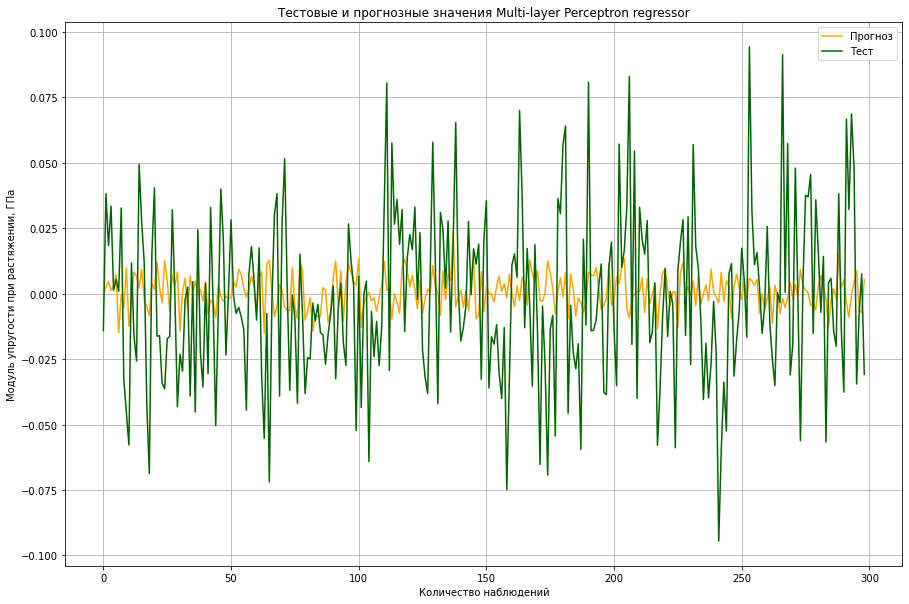

In [36]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Multi-layer Perceptron regressor")
plt.plot(y_pred_mlp, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## Лассо регрессия

In [37]:
# class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, 
#    copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

clf = Lasso(alpha=0.0001,
           max_iter = 1000000,
           random_state = 42,
           selection = 'cyclic')
clf.fit(x_train_1, y_train_1)
y_pred_clf = clf.predict(x_test_1)
mae_clf = mean_absolute_error(y_pred_clf, y_test_1)
mse_clf_elast = mean_squared_error(y_test_1,y_pred_clf)
print('Lasso regressor Results Train:')
print("Test score: {:.2f}".format(clf.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Lasso regressor Results:')
print('SGD_MAE: ', round(mean_absolute_error(y_test_1, y_pred_clf)))
print('SGD_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_clf)))
print('SGD_MSE: {:.2f}'.format(mse_clf_elast))
print("SGD_RMSE: {:.2f}".format (np.sqrt(mse_clf_elast)))
print("Test score: {:.2f}".format(clf.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Lasso regressor Results Train:
Test score: 0.00
Lasso regressor Results:
SGD_MAE:  0
SGD_MAPE: 1.03
SGD_MSE: 0.00
SGD_RMSE: 0.03
Test score: -0.01


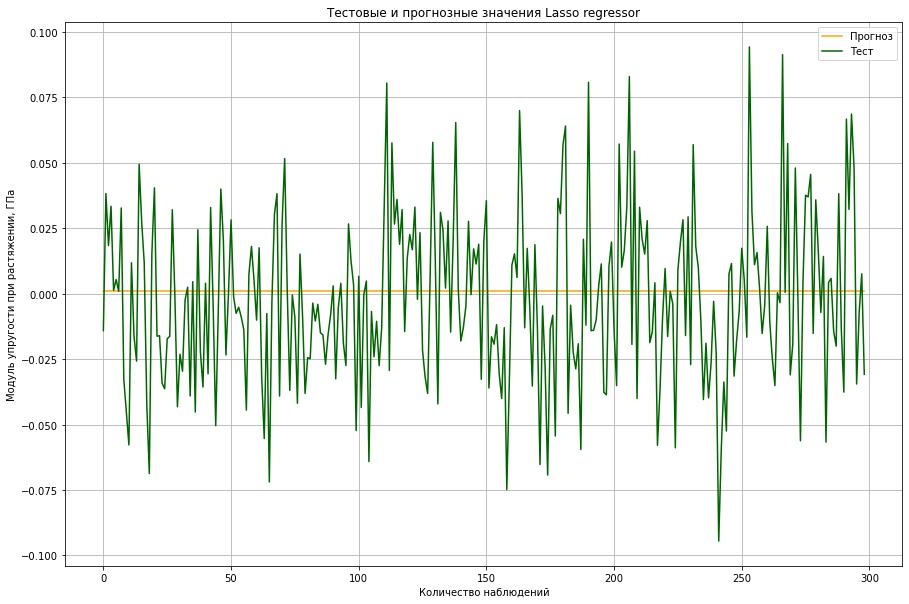

In [38]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Lasso regressor")
plt.plot(y_pred_clf, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

In [48]:
# Проведем поиск  по сетке гиперпараметров с перекрестной проверкой, количество блоков равно 10 (cv = 10), для 
#Деревья решений - Decision Tree Regressor - 6
criterion21 = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter21 = ['best', 'random']
max_depth21 = [3,5,7,9,11]
min_samples_leaf21 = [100,150,200]
min_samples_split21 = [200,250,300]
max_features21 = ['auto', 'sqrt', 'log2']
param_grid21 = {'criterion': criterion21,
               'splitter': splitter21,
               'max_depth': max_depth21,
               'min_samples_split': min_samples_split21,
               'min_samples_leaf': min_samples_leaf21,
               'max_features': max_features21}
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
# Если R2<0, это значит, что разработанная модель даёт прогноз даже хуже, чем простое усреднение.
gs21 = GridSearchCV(dtr2, param_grid21, cv = 10, verbose = 1, n_jobs=-1, scoring = 'r2')
gs21.fit(x_train_1, y_train_1)
dtr_21 = gs21.best_estimator_
gs21.best_params_

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2700 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 178, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Pois

{'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 200,
 'min_samples_split': 200,
 'splitter': 'best'}

In [49]:
#Выводим гиперпараметры для оптимальной модели
print(gs21.best_estimator_)
gs21 = gs21.best_estimator_
print(f'R2-score DTR для модуля упругости при растяжении: {gs21.score(x_test_1, y_test_1).round(3)}')

DecisionTreeRegressor(max_depth=3, max_features='auto', min_samples_leaf=200,
                      min_samples_split=200, random_state=42)
R2-score DTR для модуля упругости при растяжении: -0.017


In [58]:
dtr2 = DecisionTreeRegressor(criterion='squared_error', max_depth=2,
                      max_features='auto', min_samples_leaf=10,
                      min_samples_split=10, random_state=42)
dtr2.fit(x_train_1, y_train_1)
y_pred_dtr = dtr2.predict(x_test_1)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test_1)
mse_dtr_elast = mean_squared_error(y_test_1,y_pred_dtr)
print('Decision Tree Regressor Results Train:')
print("Test score: {:.2f}".format(knn.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Decision Tree Regressor Results:')
print('DTR_MAE: ', round(mean_absolute_error(y_test_1, y_pred_dtr)))
print('DTR_MSE: {:.2f}'.format(mse_dtr_elast))
print("DTR_RMSE: {:.2f}".format (np.sqrt(mse_dtr_elast)))
print('DTR_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_dtr)))
print("Test score: {:.2f}".format(dtr2.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Decision Tree Regressor Results Train:
Test score: 1.00
Decision Tree Regressor Results:
DTR_MAE:  1
DTR_MSE: 1.06
DTR_RMSE: 1.03
DTR_MAPE: 1.37
Test score: -0.04


# 5. Оценка точности моделей для прогнозирования свойств